In [1]:
from librosa.filters import mel
import torch

mel_basis = {}
hann_window = {}
# Spectral normalize torch
def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel_spec = mel(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel_spec).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex=False)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))
    print(spec.shape)

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec.squeeze(0))
    spec = dynamic_range_compression_torch(spec)

    return spec

In [11]:
import os, json
from scipy.io.wavfile import read
from dotmap import DotMap
from librosa.util import normalize
import torch 
import librosa
# Load and parse JSON, then convert to DotMap for attribute-style access
# with open("config-v3.json") as f:
#     data = json.load(f)

# h = DotMap(data)
MAX_WAV_VALUE = 32768.0

filename = "dataset/rec.wav"

sampling_rate, audio = read(filename)
print(audio.shape)
audio = audio / MAX_WAV_VALUE
audio = normalize(audio) * 0.95
if sampling_rate != 22050:
    # raise ValueError("{} SR doesn't match target {} SR".format(sampling_rate, 22050))
    audio = librosa.resample(audio, orig_sr=sampling_rate, target_sr=22050)

audio = torch.FloatTensor(audio)
audio = audio.unsqueeze(0)

mel_spec = mel_spectrogram(audio, n_fft=1024, num_mels=80, sampling_rate=22050, hop_size=256, win_size=1024, fmin=0, fmax=8000)


(635981,)
torch.Size([1, 513, 1242])


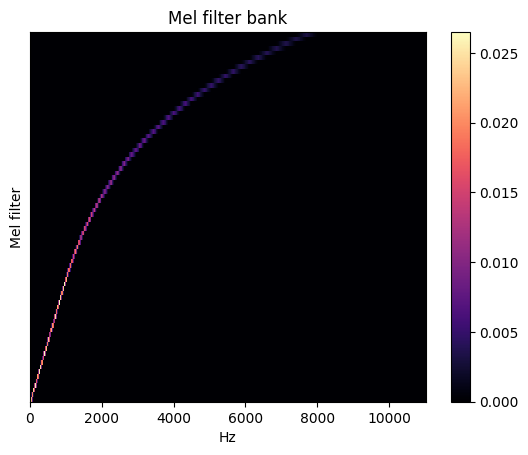

In [3]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
img = librosa.display.specshow(np.array(mel_basis[list(mel_basis.keys())[0]]), x_axis='linear', ax=ax)
ax.set(ylabel='Mel filter', title='Mel filter bank')
fig.colorbar(img, ax=ax)


torch.Size([80, 1242])


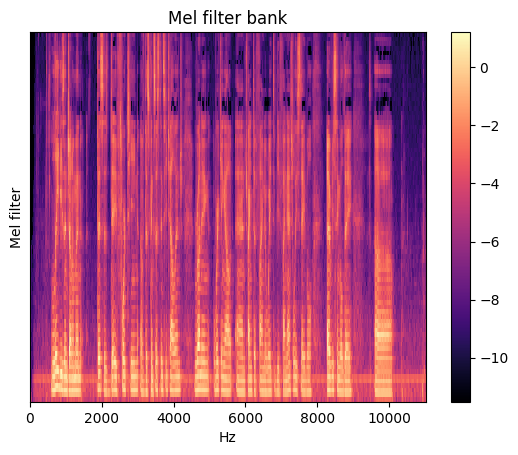

In [4]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
print(mel_spec.shape)
img = librosa.display.specshow(np.array(mel_spec), x_axis='linear', ax=ax)
ax.set(ylabel='Mel filter', title='Mel filter bank')
fig.colorbar(img, ax=ax)


Now that we can produce mel spectrograms using code mainly written by https://github.com/jik876/hifi-gan/blob/master/train.py#L15 let's have one go at inference to see if our model works 

In [10]:
from Generator import Generator
from Discriminators import MultiPeriodDiscriminator, MultiScaleDiscriminator
import jax
# Setup gen and disc

generator = Generator(channels_in=80, channels_out=1, key=jax.random.PRNGKey(69))

wave = generator(np.array(mel_spec))
print(wave.shape)


(1, 317952)
